In [1]:
from alphatools.research import run_pipeline, make_factor_plot
from alphatools.expression import ExpressionAlpha
from alphatools.ics import Sector
from alphatools.ics import SubIndustry as Industry
from zipline.pipeline.factors import AverageDollarVolume, Returns
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing as USEP

In [2]:
universe = AverageDollarVolume(window_length=120).top(2000)

In [3]:
expressions = {
    1: '(rank(ts_argmax(signedpower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)',
    2: '(-1 * correlation(rank(delta(log(volume), 2)), rank(((close - opens) / opens)), 6))',
    3: '(-1 * correlation(rank(opens), rank(volume), 10))',
    4: '(-1 * ts_rank(rank(low), 9))',
    5: '(rank((opens - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))',
    6: '(-1 * correlation(opens, volume, 10))',
    7: '((adv20 < volume) ? ((-1 * ts_rank(abs(delta(close, 7)), 60)) * sign(delta(close, 7))) : (-1* 1))',
    8:  '-1*rank(((sum(opens, 5)*sum(returns, 5))-delay((sum(opens, 5)*sum(returns, 5)),10)))',
    9: '((0 < ts_min(delta(close, 1), 5)) ? delta(close, 1) : ((ts_max(delta(close, 1), 5) < 0) ? delta(close, 1) : (-1 * delta(close, 1))))',
    10: 'rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))',
    11: '((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))',
    12: '(sign(delta(volume, 1)) * (-1 * delta(close, 1)))',
    13: '(-1 * rank(covariance(rank(close), rank(volume), 5)))',
    14: '((-1 * rank(delta(returns, 3))) * correlation(opens, volume, 10))',
    15: '(-1 * sum(rank(correlation(rank(high), rank(volume), 3)), 3))',
    16: '(-1 * rank(covariance(rank(high), rank(volume), 5)))',
    17: '(((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))',
    18: '(-1 * rank(((stddev(abs((close - opens)), 5) + (close - opens)) + correlation(close, opens,10))))',
    19: '((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + sum(returns, 250)))))',
    20: '(((-1 * rank((opens - delay(high, 1)))) * rank((opens - delay(close, 1)))) * rank((opens - delay(low, 1))))',
    21: '((((sum(close, 8) / 8) + stddev(close, 8)) < (sum(close, 2) / 2)) ? (-1 * 1) : (((sum(close, 2) / 2) < ((sum(close, 8) / 8) - stddev(close, 8))) ? 1 : (((1 < (volume / adv20)) || ((volume/adv20) == 1)) ? 1 : (-1 * 1))))',
    22: '(-1 * (delta(correlation(high, volume, 5), 5) * rank(stddev(close, 20))))',
    23: '(((sum(high, 20) / 20) < high) ? (-1 * delta(high, 2)) : 0)',
    24: '((((delta((sum(close, 100) / 100), 100) / delay(close, 100)) < 0.05) || ((delta((sum(close, 100) / 100), 100) / delay(close, 100)) == 0.05)) ? (-1 * (close - ts_min(close, 100))) : (-1 * delta(close, 3)))',
    25: 'rank(((((-1 * returns) * adv20) * vwap) * (high - close)))',
    26: '(-1 * ts_max(correlation(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))',
    27: '((0.5 < rank((sum(correlation(rank(volume), rank(vwap), 6), 2) / 2.0))) ? (-1 * 1) : 1)',
    28: 'scale(((correlation(adv20, low, 5) + ((high + low) / 2)) - close))',
    29: '(min(product(rank(rank(scale(log(sum(ts_min(rank(rank((-1 * rank(delta((close - 1),5))))), 2), 1))))), 1), 5) + ts_rank(delay((-1 * returns), 6), 5))',
    30: '(((1.0 - rank(((sign((close - delay(close, 1))) + sign((delay(close, 1) - delay(close, 2)))) + sign((delay(close, 2) - delay(close, 3)))))) * sum(volume, 5)) / sum(volume, 20))',
    31: '((rank(rank(rank(decay_linear((-1 * rank(rank(delta(close, 10)))), 10)))) + rank((-1 * delta(close, 3)))) + sign(scale(correlation(adv20, low, 12))))',
    32: '(scale(((sum(close, 7) / 7) - close)) + (20 * scale(correlation(vwap, delay(close, 5), 230))))',
    33: 'rank((-1 * ((1 - (opens / close))^1)))',
    34: 'rank(((1 - rank((stddev(returns, 2) / stddev(returns, 5)))) + (1 - rank(delta(close, 1)))))',
    35: '((ts_rank(volume, 32) * (1 - ts_rank(((close + high) - low), 16))) * (1 - ts_rank(returns, 32))) ',
    36: '(((((2.21 * rank(correlation((close - opens), delay(volume, 1), 15))) + (0.7 * rank((opens - close)))) + (0.73 * rank(ts_rank(delay((-1 * returns), 6), 5)))) + rank(abs(correlation(vwap, adv20, 6)))) + (0.6 * rank((((sum(close, 200) / 200) - opens) * (close - opens))))) ',
    37: '(rank(correlation(delay((opens - close), 1), close, 200)) + rank((opens - close))) ',
    38: '((-1 * rank(ts_rank(close, 10))) * rank((close / opens)))',
    39: '((-1 * rank((delta(close, 7) * (1 - rank(decay_linear((volume / adv20), 9)))))) * (1 + rank(sum(returns, 250))))',
    40: '((-1 * rank(stddev(high, 10))) * correlation(high, volume, 10))',
    41: '(((high * low)^0.5) - vwap) ',
    42: '(rank((vwap - close)) / rank((vwap + close)))',
    43: '(ts_rank((volume / adv20), 20) * ts_rank((-1 * delta(close, 7)), 8)) ',
    44: '(-1 * correlation(high, rank(volume), 5)) ',
    45: '(-1 * ((rank((sum(delay(close, 5), 20) / 20)) * correlation(close, volume, 2)) *rank(correlation(sum(close, 5), sum(close, 20), 2)))) ',
    46: '((0.25 < (((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10))) ? (-1 * 1) : (((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < 0) ? 1 : ((-1 * 1) * (close - delay(close, 1))))) ',
    47: '((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / (sum(high, 5) / 5))) - rank((vwap - delay(vwap, 5)))) ',
    48: '(indneutralize(((correlation(delta(close, 1), delta(delay(close, 1), 1), 250) * delta(close, 1)) / close), IndClass.subindustry) / sum(((delta(close, 1) / delay(close, 1))^2), 250)) ',
    49: '(((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.1)) ? 1 : ((-1 * 1) * (close - delay(close, 1))))',
    50: '(-1 * ts_max(rank(correlation(rank(volume), rank(vwap), 5)), 5)) ',
    51: '(((((delay(close, 20) - delay(close, 10)) / 10) - ((delay(close, 10) - close) / 10)) < (-1 *0.05)) ? 1 : ((-1 * 1) * (close - delay(close, 1)))) ',
    52: '((((-1 * ts_min(low, 5)) + delay(ts_min(low, 5), 5)) * rank(((sum(returns, 240) - sum(returns, 20)) / 220))) * ts_rank(volume, 5)) ',
    53: '(-1*delta((((close-low) - (high-close)) / (close-low)), 9))',
    54: '((-1 * ((low - close) * (opens^5))) / ((low - high) * (close^5)))',
    55: '(-1 * correlation(rank(((close - ts_min(low, 12)) / (ts_max(high, 12) - ts_min(low,12)))), rank(volume), 6))',
    56: '(0 - (1 * (rank((sum(returns, 10) / sum(sum(returns, 2), 3))) * rank((returns * cap)))))',
    57: '(0 - (1*((close - vwap)/decay_linear(rank(ts_argmax(close, 30)),2))))',
    58: '(-1 * ts_rank(decay_linear(correlation(indneutralize(vwap, IndClass.sector), volume,3.92795), 7.89291), 5.50322)) ',
    59: '(-1 * ts_rank(decay_linear(correlation(indneutralize(((vwap * 0.728317) + (vwap *(1 - 0.728317))), IndClass.industry), volume, 4.25197), 16.2289), 8.19648)) ',
    60: '(0 - (1 * ((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10)))))) ',
    61: '(rank((vwap - ts_min(vwap, 16.1219))) < rank(correlation(vwap, adv180, 17.9282))) ',
    62: '((rank(correlation(vwap, sum(adv20, 22.4101), 9.91009)) < rank(((rank(opens) + rank(opens)) < (rank(((high + low) / 2)) + rank(high))))) * -1) ',
    63: '((rank(decay_linear(delta(indneutralize(close, IndClass.industry), 2.25164), 8.22237)) - rank(decay_linear(correlation(((vwap * 0.318108) + (opens * (1 - 0.318108))), sum(adv180,37.2467), 13.557), 12.2883))) * -1) ',
    64: '((rank(correlation(sum(((opens * 0.178404) + (low * (1 - 0.178404))), 12.7054),sum(adv120, 12.7054), 16.6208)) < rank(delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1) ',
    65: '((rank(correlation(((opens * 0.00817205) + (vwap * (1 - 0.00817205))), sum(adv60,8.6911), 6.40374)) < rank((opens - ts_min(opens, 13.635)))) * -1) ',
    66: '((rank(decay_linear(delta(vwap, 3.51013), 7.23052)) + ts_rank(decay_linear(((((low* 0.96633) + (low * (1 - 0.96633))) - vwap) / (opens - ((high + low) / 2))), 11.4157), 6.72611)) * -1) ',
    67: '((rank((high - ts_min(high, 2.14593)))^rank(correlation(indneutralize(vwap,IndClass.sector), indneutralize(adv20, IndClass.subindustry), 6.02936))) * -1) ',
    68: '((ts_rank(correlation(rank(high), rank(adv15), 8.91644), 13.9333) < rank(delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1) ', 
    69: '((rank(ts_max(delta(indneutralize(vwap, IndClass.industry), 2.72412),4.79344))^ts_rank(correlation(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615)) * -1) ',
    70: '((rank(delta(vwap, 1.29456))^ts_rank(correlation(indneutralize(close,IndClass.industry), adv50, 17.8256), 17.9171)) * -1) ',
    71: 'max(ts_rank(decay_linear(correlation(ts_rank(close, 3.43976), ts_rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), ts_rank(decay_linear((rank(((low + opens) - (vwap + vwap)))^2), 16.4662), 4.4388))',
    72: '(rank(decay_linear(correlation(((high + low) / 2), adv40, 8.93345), 10.1519)) / rank(decay_linear(correlation(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671),2.95011))) ',
    73: '(max(rank(decay_linear(delta(vwap, 4.72775), 2.91864)), ts_rank(decay_linear(((delta(((opens * 0.147155) + (low * (1 - 0.147155))), 2.03608) / ((opens * 0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1) ',
    74: '((rank(correlation(close, sum(adv30, 37.4843), 15.1365)) <rank(correlation(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1) ',
    75: '(rank(correlation(vwap, volume, 4.24304)) < rank(correlation(rank(low), rank(adv50),12.4413)))',
    76: '(max(rank(decay_linear(delta(vwap, 1.24383), 11.8259)),ts_rank(decay_linear(ts_rank(correlation(indneutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1) ',
    77: 'min(rank(decay_linear(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),rank(decay_linear(correlation(((high + low) / 2), adv40, 3.1614), 5.64125))) ',
    78: '(rank(correlation(sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),sum(adv40, 19.7428), 6.83313))^rank(correlation(rank(vwap), rank(volume), 5.77492))) ',
    79: '(rank(delta(indneutralize(((close * 0.60733) + (opens * (1 - 0.60733))),IndClass.sector), 1.23438)) < rank(correlation(ts_rank(vwap, 3.60973), ts_rank(adv150,9.18637), 14.6644))) ',
    80: '((rank(sign(delta(indneutralize(((opens * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545)))^ts_rank(correlation(high, adv10, 5.11456), 5.53756)) * -1) ',
    81: '((rank(log(product(rank((rank(correlation(vwap, sum(adv10, 49.6054),8.47743))^4)), 14.9655))) < rank(correlation(rank(vwap), rank(volume), 5.07914))) * -1) ',
    82: '(min(rank(decay_linear(delta(opens, 1.46063), 14.8717)),ts_rank(decay_linear(correlation(indneutralize(volume, IndClass.sector), ((opens * 0.634196) +(opens * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1) ',
    83: '((rank(delay(((high - low) / (sum(close, 5) / 5)), 2)) * rank(rank(volume))) / (((high -low) / (sum(close, 5) / 5)) / (vwap - close))) ',
    84: 'signedpower(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), delta(close,4.96796)) ',
    85: '(rank(correlation(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331))^rank(correlation(ts_rank(((high + low) / 2), 3.70596), ts_rank(volume, 10.1595),7.11408))) ',
    86: '((ts_rank(correlation(close, sum(adv20, 14.7444), 6.00049), 20.4195) < rank(((opens+ close) - (vwap + opens)))) * -1) ',
    87: '(max(rank(decay_linear(delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), ts_rank(decay_linear(abs(correlation(indneutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1) ',
    88: 'min(rank(decay_linear(((rank(opens) + rank(low)) - (rank(high) + rank(close))),8.06882)), ts_rank(decay_linear(correlation(ts_rank(close, 8.44728), ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957)) ',
    89: '(ts_rank(decay_linear(correlation(((low * 0.967285) + (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - ts_rank(decay_linear(delta(indneutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012)) ',
    90: '((rank((close - ts_max(close, 4.66719)))^ts_rank(correlation(indneutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1) ',
    91: '((ts_rank(decay_linear(decay_linear(correlation(indneutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -rank(decay_linear(correlation(vwap, adv30, 4.01303), 2.6809))) * -1) ',
    92: 'min(ts_rank(decay_linear(((((high + low) / 2) + close) < (low + opens)), 14.7221),18.8683), ts_rank(decay_linear(correlation(rank(low), rank(adv30), 7.58555), 6.94024),6.80584)) ',
    93: '(ts_rank(decay_linear(correlation(indneutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / rank(decay_linear(delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664))) ',
    94: '((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(correlation(ts_rank(vwap,19.6462), ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)',
    95: '(rank((opens - ts_min(opens, 12.4105))) < ts_rank((rank(correlation(sum(((high + low)/ 2), 19.1351), sum(adv40, 19.1351), 12.8742))^5), 11.7584)) ',
    96: '(max(ts_rank(decay_linear(correlation(rank(vwap), rank(volume), 3.83878),4.16783), 8.38151), ts_rank(decay_linear(ts_argmax(correlation(ts_rank(close, 7.45404),ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)',
    97: '((rank(decay_linear(delta(indneutralize(((low * 0.721001) + (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) - ts_rank(decay_linear(ts_rank(correlation(ts_rank(low,7.87871), ts_rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1) ',
    98: '(rank(decay_linear(correlation(vwap, sum(adv5, 26.4719), 4.58418), 7.18088)) -rank(decay_linear(ts_rank(ts_argmin(correlation(rank(opens), rank(adv15), 20.8187), 8.62571),6.95668), 8.07206))) ',
    99: '((rank(correlation(sum(((high + low) / 2), 19.8975), sum(adv60, 19.8975), 8.8136)) <rank(correlation(low, volume, 6.28259))) * -1) ',
    100: '(0 - (1 * (((1.5 * scale(indneutralize(indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), IndClass.subindustry), IndClass.subindustry))) -scale(indneutralize((correlation(close, rank(adv20), 5) - rank(ts_argmin(close, 30))),IndClass.subindustry))) * (volume / adv20)))) ',
    101: '((close - opens) / ((high - low) + .001))'
}


In [18]:
alphas = {
    102: 'scale((close > delay(close, 1)) ? opens : delay(opens, 1))',
    103: '-rank(stddev(returns, 60))*log(close/delay(close,5))',
    104: 'product(1+returns, 20)',
    105: 'rank(indneutralize(close))',
    106: '(returns > 0) ? factory("sample") : -sum(returns, 5)',
    107: '(factory("other") > 0) ? factory("sample") : -sum(returns, 5)',
    'test': '-delta(close, 1)',
    'test1': '(delta(close, 5)/delay(close,5))',
    'test2': 'rank((-(delta(close, 5)/(delay(close,5)))))',
    'test3': 'rank(indneutralize(-(delta(close, 5)/close)))',
}

In [19]:
import json


In [20]:
#with open('one_o_one_alphas.json', 'ws') as fp:
#    json.dump(expressions, fp, indent=4)

In [21]:
expr = {}
with open('one_o_one_alphas.json', 'rs') as fp:
    expr = json.load(fp)

In [22]:
expr

{u'1': u'(rank(ts_argmax(signedpower(((returns < 0) ? stddev(returns, 20) : close), 2.), 5)) - 0.5)',
 u'10': u'rank(((0 < ts_min(delta(close, 1), 4)) ? delta(close, 1) : ((ts_max(delta(close, 1), 4) < 0) ? delta(close, 1) : (-1 * delta(close, 1)))))',
 u'100': u'(0 - (1 * (((1.5 * scale(indneutralize(indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), IndClass.subindustry), IndClass.subindustry))) -scale(indneutralize((correlation(close, rank(adv20), 5) - rank(ts_argmin(close, 30))),IndClass.subindustry))) * (volume / adv20)))) ',
 u'101': u'((close - opens) / ((high - low) + .001))',
 u'11': u'((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) * rank(delta(volume, 3)))',
 u'12': u'(sign(delta(volume, 1)) * (-1 * delta(close, 1)))',
 u'13': u'(-1 * rank(covariance(rank(close), rank(volume), 5)))',
 u'14': u'((-1 * rank(delta(returns, 3))) * correlation(opens, volume, 10))',
 u'15': u'(-1 * sum(rank(correlation(rank(high), rank(volume), 3)

In [32]:
idx = 2
#e = ExpressionAlpha(expr['9'])
#f = ExpressionAlpha(expressions['test'])
e = ExpressionAlpha(alphas[106])

In [33]:
e.parse()
print(e.tree.pretty())

ternary
  greaterthan
    returns
    number	0
  factory	"sample"
  neg
    sum
      returns
      5



In [34]:
!pwd

/Users/jonathan/devwork/alphatools/notebooks


In [35]:
from lark.tree import pydot__tree_to_png
pydot__tree_to_png(e.tree, "alpha" + str(idx) + ".png")

In [36]:
def save_pngs(start=55, end=70):
    for i in range(start, end+1):
        print i
        e = ExpressionAlpha(expressions[i])
        e.parse()
        pydot__tree_to_png(e.tree, "alpha" + str(i) + ".png")

In [37]:
#save_pngs(90,101)

In [38]:
e.transform()

<alphatools.expression.expression.ExpressionAlpha instance at 0x1c1c9c62d8>

In [39]:
e.generate_pipeline_code()
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), Factory["sample"].value]
    window_length = 7

    def compute(self, today, assets, out, returns, factory0):
        v0 = np.greater(returns, 0)
        v1 = pd.DataFrame(data=returns).rolling(
            window=5, center=False, min_periods=1).sum().values
        v2 = -v1
        v3 = np.where(v0, factory0, v2)
        out[:] = v3[-1]



In [17]:
e.imports

'from __future__ import division\nfrom alphatools.data import Factory\nfrom zipline.pipeline.factors import Returns\nfrom zipline.pipeline.factors import CustomFactor\nimport numpy as np\nimport bottleneck as bn\nimport pandas as pd\n'

In [18]:
expr_factor = (
    ExpressionAlpha('rank(log(close/delay(close, 5)))').
    make_pipeline_factor().
    pipeline_factor(mask=universe)
)

In [19]:
p = Pipeline(screen=universe)

mr_fac = -Returns(window_length=5, mask=universe).demean(groupby=Industry()).rank()
mr_fac = -Returns(window_length=5, mask=universe).rank()
mr_fac = -Returns(window_length=5)

#p.add(mr_fac, 'Control')
#p.add(USEP.close.latest, 'Control_close')
p.add(e.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha")
#p.add(f.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha1")
#p.add(g.make_pipeline_factor().pipeline_factor(mask=universe), "Expression Alpha2")

start_date = '2014-01-02'
end_date = '2018-01-02'

df = run_pipeline(p, start_date, end_date)

In [20]:
df

Expression Alpha
2014-01-02 00:00:00+00:00 Equity(0 [A])               -0.000397
                          Equity(2 [AAL])              0.002504
                          Equity(3 [AAMC])             0.008796
                          Equity(4 [AAN])              0.000004
                          Equity(7 [AAP])              0.002524
                          Equity(8 [AAPL])             0.000469
                          Equity(9 [AAT])             -0.002618
                          Equity(10 [AAWW])           -0.000069
                          Equity(11 [ABAX])           -0.000209
                          Equity(12 [ABBV])           -0.000211
                          Equity(13 [ABC])            -0.000032
                          Equity(15 [ABCO])            0.005904
                          Equity(16 [ABFS])           -0.001148
                          Equity(17 [ABG])             0.000252
                          Equity(18 [ABM])            -0.001989
                          Equity(19 [ABMD])           -0.002281
                          Equity(20 [ABT])            -0.000279
                          Equity(21 [ACAD])           -0.004541
                          Equity(22 [ACAS])            0.002868
                          Equity(23 [ACAT])            0.000350
                          Equity(24 [ACC])            -0.000817
                          Equity(26 [ACCO])            0.000042
                          Equity(27 [ACE])             0.000465
                          Equity(28 [ACET])            0.006631
                          Equity(30 [ACGL])            0.002163
                          Equity(31 [ACHC])           -0.001801
                          Equity(32 [ACHN])            0.000543
                          Equity(33 [ACI])            -0.000270
                          Equity(34 [ACIW])            0.000065
                          Equity(36 [ACM])             0.001708
...                                                         ...
2018-01-02 00:00:00+00:00 Equity(3149 [XEL])           0.000615
                          Equity(3150 [XL])           -0.005854
                          Equity(3151 [XLNX])         -0.015554
                          Equity(3152 [XLRN])         -0.019380
                          Equity(3154 [XNCR])         -0.028014
                          Equity(3156 [XOM])          -0.004468
                          Equity(3157 [XOMA])          0.001669
                          Equity(3158 [XON])           0.016585
                          Equity(3162 [XPO])           0.002383
                          Equity(3163 [XRAY])         -0.008942
                          Equity(3165 [XRX])          -0.010090
                          Equity(3167 [XXII])         -0.037460
                          Equity(3168 [XYL])          -0.000726
                          Equity(3169 [Y])            -0.000848
                          Equity(3171 [YELP])         -0.006346
                          Equity(3174 [YRCW])         -0.010927
                          Equity(3175 [YUM])          -0.012739
                          Equity(3177 [Z])            -0.011999
                          Equity(3178 [ZAGG])         -0.060733
                          Equity(3180 [ZBH])          -0.008826
                          Equity(3181 [ZBRA])         -0.004582
                          Equity(3182 [ZEN])          -0.002935
                          Equity(3184 [ZEUS])         -0.009644
                          Equity(3185 [ZGNX])         -0.050795
                          Equity(3188 [ZION])         -0.009909
                          Equity(3189 [ZIOP])          0.034930
                          Equity(3194 [ZNGA])          0.007545
                          Equity(3195 [ZOES])         -0.032934
                          Equity(3197 [ZTS])          -0.004833
                          Equity(3198 [ZUMZ])         -0.017689

[2016000 rows x 1 columns]

In [33]:
1/2

0

In [34]:
df.tail()

Expression Alpha
2018-01-02 00:00:00+00:00 Equity(3189 [ZIOP])         -0.533930
                          Equity(3194 [ZNGA])         -0.299350
                          Equity(3195 [ZOES])         -0.190766
                          Equity(3197 [ZTS])          -0.229730
                          Equity(3198 [ZUMZ])         -0.152187

Formatting factor data for: Expression Alpha
Dropped 0.6% entries from factor data: 0.6% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 14.97 secs
Time to generate long/short returns: 0.92 secs


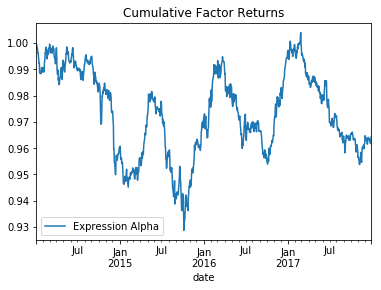

In [35]:
make_factor_plot(df, start_date, end_date);

In [27]:
e = ExpressionAlpha('rank(log(close/delay(opens, 5)))').parse().transform().generate_pipeline_code()

In [28]:
print(e.pipeline_code)

class ExprAlpha_1(CustomFactor):
    inputs = [Returns(window_length=2), USEP.open, USEP.high,
              USEP.low, USEP.close, USEP.volume]
    window_length = 7

    def compute(self, today, assets, out, returns, opens, high, low, close, volume):
        v22 = np.roll(opens, 5, axis=0)
        v23 = close / v22
        v24 = np.log(v23)
        v25 = np.apply_along_axis(rankdata, 1, v24)
        out[:] = v25[-1]



In [29]:
#M,T,W,Th,F
# delay(5) --> prior friday
# returns(window=6)

NameError: name 'a' is not defined

In [18]:
b

array([[ 0.54254437,  0.14217005],
       [ 0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399],
       [ 0.61776698,  0.51313824],
       [ 0.65039718,  0.60103895],
       [ 0.8052232 ,  0.52164715],
       [ 0.90864888,  0.31923609],
       [ 0.09045935,  0.30070006],
       [ 0.11398436,  0.82868133],
       [ 0.04689632,  0.62628715]])

In [86]:
def column_corr((a, b), window=-1):
    if window==-1:
        window = a.shape[0]
    out = np.zeros(shape = (1, a.shape[1]))
    for i in xrange(a.shape[1]-1):
        out[i] = pearsonr(a[-window:, i], b[-window:, i])[0]
    return out
        

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
np.random.seed(10)
a = np.random.random(30).reshape(10,3)
b = np.random.random(30).reshape(10,3)

In [21]:
a[1,1]

0.49850701230259042

In [22]:
a_1 = pd.DataFrame(a)
b_1 = pd.DataFrame(b)



In [15]:
def roll_corr((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

In [36]:
a

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [37]:
np.roll(a, 2, axis=0)

array([[ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895],
       [ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362]])

In [16]:
%%timeit
out = roll_corr((a,b), window=5)

1000 loops, best of 3: 645 µs per loop


In [23]:
%%timeit
out = pd.rolling_corr(arg1=a_1, arg2=b_1, window=5)

/anaconda3/envs/py27_clean/lib/python2.7/site-packages/ipykernel_launcher.py:257: FutureWarning: pd.rolling_corr is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=5).corr(other=<DataFrame>)


100 loops, best of 3: 10.1 ms per loop


In [12]:
out[-1]

NameError: name 'out' is not defined

In [5]:
#from __future__ import division
v0 = (np.arange(5)+1.)/np.sum(np.arange(5)+1.)

out = a_1.rolling(5).apply(lambda x: (x*v0).sum()).values

In [6]:
v0

array([ 0.06666667,  0.13333333,  0.2       ,  0.26666667,  0.33333333])

In [27]:
out[-1, :]

array([ 0.48050722,  0.55059807,  0.59170856])

In [18]:
from numba import jit

In [19]:
@jit
def roll_corr2((a, b), window):
    out = np.ones_like(a)*np.nan
    for i in xrange(window-1, a.shape[0]):   # 2- 10
        #print "%d --> %d" % ((i-(window-1)), i)
        for j in xrange(a.shape[1]):
            out[i, j] = pearsonr(
                a[(i-(window-1)):(i), j], b[(i-(window-1)):(i), j]
            )[0]
    return out

ValueError: '.0' is not a valid parameter name

In [207]:
def scale(x):
    return (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x)))

In [211]:
np.apply_along_axis(lambda x: (x - np.nanmean(x))/np.nansum(np.abs(x - np.nanmean(x))), 1, a)

array([[ 0.32572934, -0.5       ,  0.17427066],
       [ 0.4853247 ,  0.0146753 , -0.5       ],
       [-0.23118186,  0.5       , -0.26881814],
       [-0.5       ,  0.11250682,  0.38749318],
       [-0.5       ,  0.07890222,  0.42109778],
       [ 0.14084777,  0.35915223, -0.5       ],
       [ 0.5       , -0.02694105, -0.47305895],
       [-0.45819778, -0.04180222,  0.5       ],
       [-0.23369585, -0.26630415,  0.5       ],
       [-0.5       ,  0.41441077,  0.08558923]])

array([[ 0.77132064,  0.02075195,  0.63364823],
       [ 0.74880388,  0.49850701,  0.22479665],
       [ 0.19806286,  0.76053071,  0.16911084],
       [ 0.08833981,  0.68535982,  0.95339335],
       [ 0.00394827,  0.51219226,  0.81262096],
       [ 0.61252607,  0.72175532,  0.29187607],
       [ 0.91777412,  0.71457578,  0.54254437],
       [ 0.14217005,  0.37334076,  0.67413362],
       [ 0.44183317,  0.43401399,  0.61776698],
       [ 0.51313824,  0.65039718,  0.60103895]])

In [33]:
from __future__ import division

np.sum()

1.0

55

In [65]:
import bottleneck as bn
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, rankdata
np.random.seed(2)
a = np.random.random(60).reshape(20,3)    # days x stocks
b = np.random.randint(2, 5, size=(1,3))   # Industry cat vars as integers

In [22]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [25]:
b.max()+2

6

In [26]:
ohe = np.zeros((b.size, b.max()+2))
ohe[np.arange(b.size),b+1] = 1

In [27]:
ohe.T

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  1.]])

In [38]:
ind_mean = np.nan_to_num(a.dot(ohe)/ohe.sum(axis=0))

In [39]:
ind_mean

array([[ 0.        ,  0.        ,  0.        ,  0.02592623,  0.        ,
         0.49282869],
       [ 0.        ,  0.        ,  0.        ,  0.4203678 ,  0.        ,
         0.38282861],
       [ 0.        ,  0.        ,  0.        ,  0.61927097,  0.        ,
         0.25215165],
       [ 0.        ,  0.        ,  0.        ,  0.62113383,  0.        ,
         0.39798468],
       [ 0.        ,  0.        ,  0.        ,  0.51357812,  0.        ,
         0.15950991],
       [ 0.        ,  0.        ,  0.        ,  0.85397529,  0.        ,
         0.63978599],
       [ 0.        ,  0.        ,  0.        ,  0.07964548,  0.        ,
         0.67590379],
       [ 0.        ,  0.        ,  0.        ,  0.42812233,  0.        ,
         0.08090871],
       [ 0.        ,  0.        ,  0.        ,  0.59674531,  0.        ,
         0.17658599],
       [ 0.        ,  0.        ,  0.        ,  0.22030621,  0.        ,
         0.22838598]])

In [40]:
per_stock_ind_mean = ind_mean.dot(ohe.T)

In [41]:
per_stock_ind_mean # per stock ind_mean by day!

array([[ 0.49282869,  0.02592623,  0.49282869],
       [ 0.38282861,  0.4203678 ,  0.38282861],
       [ 0.25215165,  0.61927097,  0.25215165],
       [ 0.39798468,  0.62113383,  0.39798468],
       [ 0.15950991,  0.51357812,  0.15950991],
       [ 0.63978599,  0.85397529,  0.63978599],
       [ 0.67590379,  0.07964548,  0.67590379],
       [ 0.08090871,  0.42812233,  0.08090871],
       [ 0.17658599,  0.59674531,  0.17658599],
       [ 0.22838598,  0.22030621,  0.22838598]])

In [42]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [43]:
a - per_stock_ind_mean

array([[-0.05683379,  0.        ,  0.05683379],
       [ 0.05249379,  0.        , -0.05249379],
       [-0.04750302,  0.        ,  0.04750302],
       [-0.13115741,  0.        ,  0.13115741],
       [-0.02492996,  0.        ,  0.02492996],
       [ 0.14554916,  0.        , -0.14554916],
       [ 0.1706577 ,  0.        , -0.1706577 ],
       [-0.01562221,  0.        ,  0.01562221],
       [-0.04942601,  0.        ,  0.04942601],
       [-0.1214403 ,  0.        ,  0.1214403 ]])

In [33]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [34]:
a.shape

(10, 3)

In [35]:
bn.nanargmin(a, axis=0)

array([7, 0, 7])

In [36]:
np.argmax(a, axis=0)

array([6, 5, 0])

In [28]:
np.max(a, axis=0)

array([ 0.84656149,  0.85397529,  0.54966248])

In [25]:
a

array([[ 0.4359949 ,  0.02592623,  0.54966248],
       [ 0.43532239,  0.4203678 ,  0.33033482],
       [ 0.20464863,  0.61927097,  0.29965467],
       [ 0.26682728,  0.62113383,  0.52914209],
       [ 0.13457995,  0.51357812,  0.18443987],
       [ 0.78533515,  0.85397529,  0.49423684],
       [ 0.84656149,  0.07964548,  0.50524609],
       [ 0.0652865 ,  0.42812233,  0.09653092],
       [ 0.12715997,  0.59674531,  0.226012  ],
       [ 0.10694568,  0.22030621,  0.34982629]])

In [43]:
eps = 7./3 - 4./3 -1

array([[ 0.48129143,  0.1       ,  0.5869822 ],
       [ 0.48066611,  0.46676099,  0.38304622],
       [ 0.26618026,  0.65170579,  0.3545191 ],
       [ 0.32399542,  0.65343793,  0.56790186],
       [ 0.20102876,  0.55343012,  0.24738968],
       [ 0.80611615,  0.86993936,  0.53544614],
       [ 0.86304583,  0.14994941,  0.5456828 ],
       [ 0.1365981 ,  0.47397132,  0.16564988],
       [ 0.1941295 ,  0.63076091,  0.28604442],
       [ 0.17533378,  0.28073904,  0.40116984],
       [ 0.51085291,  0.26347875,  0.67135832],
       [ 0.5250628 ,  0.54567409,  0.43563501],
       [ 0.81383583,  0.61519462,  0.22680221],
       [ 0.72746909,  0.97275531,  0.54081264],
       [ 0.90298972,  0.39353354,  0.60323704],
       [ 0.47343541,  0.48199099,  0.79795605],
       [ 0.57391046,  0.96270499,  0.58191064],
       [ 0.15222696,  0.41652691,  0.86703386],
       [ 0.45365721,  0.10118658,  0.30572435],
       [ 0.13832559,  1.        ,  0.97836143]])

In [70]:
z = (bn.move_rank(a, window=10, axis=0))
np.interp(z, (z.min(), z.max()), (0.1, +1))

array([[ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan],
       [ nan,  nan,  nan]])

In [8]:
np.apply_along_axis(rankdata, axis=1, arr=a)

array([[ 2.,  1.,  3.],
       [ 3.,  2.,  1.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 2.,  3.,  1.],
       [ 3.,  1.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  2.,  3.]])

In [11]:
ranks = np.apply_along_axis(rankdata, axis=1, arr=a)

In [24]:
counts = np.sum(~np.isnan(ranks), axis=1).reshape(10,1)

In [25]:
ranks

array([[ 2.,  1.,  3.],
       [ 3.,  2.,  1.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 2.,  3.,  1.],
       [ 3.,  1.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  3.,  2.],
       [ 1.,  2.,  3.]])

In [26]:
np.divide(ranks, counts)

array([[ 0.66666667,  0.33333333,  1.        ],
       [ 1.        ,  0.66666667,  0.33333333],
       [ 0.33333333,  1.        ,  0.66666667],
       [ 0.33333333,  1.        ,  0.66666667],
       [ 0.33333333,  1.        ,  0.66666667],
       [ 0.66666667,  1.        ,  0.33333333],
       [ 1.        ,  0.33333333,  0.66666667],
       [ 0.33333333,  1.        ,  0.66666667],
       [ 0.33333333,  1.        ,  0.66666667],
       [ 0.33333333,  0.66666667,  1.        ]])